In [3]:
from selenium import webdriver
from tqdm import tqdm
import requests
import time
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [4]:
# INSTANTIATE DRIVER -> REPLACE WITH YOUR WEBBROWSER
driver = webdriver.Edge()
driver.get("https://www.ecb.europa.eu/press/pressconf/html/index.en.html")

# SCROLL THROUGH THE WEBPAGE TO LOAD ALL CONTENT
for x in range(0, 10000, 200):
    driver.execute_script("window.scrollBy(0, " +str(x)+");")
    time.sleep(0.5)

In [5]:
# GET WEBPAGE SOURCE CONTENT
html = driver.page_source
title = driver.title
soup = BeautifulSoup(html)

In [6]:
# LOOK FOR ALL LINKS PRESENT IN THE WEBPAGE
r = []
for i in soup.find_all("a", href=True):
    r.append(i["href"])

# REMOVE DUPLICATES
r = list(set(r))

# CONSTRUCT DATAFRAME
df = pd.DataFrame(r, columns=["link"])
df = df.sort_values("link")

In [7]:
df = df.loc[
   (df['link'].str.contains("press_conference/monetary-policy")) &
   (df['link'].str.contains(".en.html"))
   ]

In [8]:
content = []
date = []
title = []

print(f"TOTAL DOCUMENTS : {len(df)}")

for i, x in tqdm(df.iterrows(), total=df.shape[0]):

    url = "https://www.ecb.europa.eu" + x["link"]

    try:
        req = requests.get(url)
        soup = BeautifulSoup(req.content, 'html.parser')

        c = []
        sections = soup.find_all("div", {"class":"section"})
        for section in sections:
            for text_container in section.find_all(["h2","p"]):
                c.append(text_container.text.strip())

        content.append("\n".join(c))

        h1_tag = soup.find("h1")
        titre_ajouté = False

        if h1_tag:
            h1_text = h1_tag.text.strip()
            if ("introductory statement" in h1_text.lower()) or ("monetary policy statement" in h1_text.lower()or ("press conference" in h1_text.lower())):
                title.append(h1_text)
                titre_ajouté = True

        if not titre_ajouté:
            title.append(None)

        meta_date = soup.find("meta", {"property":"article:published_time"})
        date_ajoutée = False

        if meta_date:
            date_str = meta_date["content"]
            date.append(date_str)
            date_ajoutée = True

        if not date_ajoutée:
            date.append(None)

    except Exception as e:
        print(f"Erreur sur le lien {url}: {e}")
        content.append("")
        title.append(None)
        date.append(None)

df["content"] = content
df["date"] = date
df["title"] = title

df = df.dropna(subset=["title", "date"])

TOTAL DOCUMENTS : 293


100%|██████████| 293/293 [01:15<00:00,  3.88it/s]


In [9]:
# 1. Convertir la date et extraire l'année
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# 2. Filtrer pour exclure 1998
df = df[df['year'] != 1998]

# 3. Exclure les liens indésirables
liens_intrus = [
    '/press/press_conference/monetary-policy-statement/2000/html/is000330.en.html',
    '/press/press_conference/monetary-policy-statement/2000/html/is001019.en.html',
    '/press/press_conference/monetary-policy-statement/2001/html/is011213.en.html',
    '/press/press_conference/monetary-policy-statement/2002/html/is020103_2.en.html',
    '/press/press_conference/monetary-policy-statement/2003/html/is030917.en.html',
    '/press/press_conference/monetary-policy-statement/2003/html/is031013.en.html',
    '/press/press_conference/monetary-policy-statement/2005/html/is050120.en.html',
    '/press/press_conference/monetary-policy-statement/2005/html/is050120_1.en.html',
    '/press/press_conference/monetary-policy-statement/2014/html/is141026.en.html',
    '/press/press_conference/monetary-policy-statement/2021/html/ecb.sp210708~ab68c3bd9d.en.html',
    '/press/press_conference/monetary-policy-statement/html/index.en.html'
]

df = df[~df['link'].isin(liens_intrus)]

In [10]:
# 4. Vérifier le résultat
comptage_par_annee = df['year'].value_counts().sort_index()
print("Nombre de documents par année :")
print(comptage_par_annee)
print(f"\nTotal des documents : {len(df)}")

Nombre de documents par année :
year
1999    11
2000    11
2001    11
2002    11
2003    11
2004    11
2005    11
2006    12
2007    11
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015     8
2016     8
2017     8
2018     8
2019     8
2020     8
2021     8
2022     8
2023     8
2024     8
2025     8
Name: count, dtype: int64

Total des documents : 272


In [11]:
stops = stopwords.words("english")
porter = PorterStemmer()

In [12]:
def clean_text(text):

    text = text.lower()

    markers = [
        "we are now at your disposal",
        "we stand ready to answer any questions you may have",
        "transcript of the questions asked and the answers",
        "question",
        "questions"
    ]

    for marker in markers:
        if marker in text:
            text = text.split(marker)[0]
            break

    if marker in text:
         text = text.split(marker)[0]

    if type(text) != str:
        return np.nan

    text = text.lower()
    text = re.sub(r"[^'a-z\s-]", " ", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stops]
    tokens = [porter.stem(t) for t in tokens]

    return " ".join(tokens)
df['clean_text'] = df['content'].apply(clean_text)
texts = df['clean_text'].tolist()

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cv = CountVectorizer(
    ngram_range=(2, 2),
    stop_words=None,
    binary=True
)

# 2. Création de la matrice X
# Lignes = Documents, Colonnes = Bigrammes uniques
# C'est une "Sparse Matrix" (matrice creuse) optimisée pour la mémoire
X = cv.fit_transform(df['clean_text'])

# 3. Calcul de la similarité (i vs i-1)
results = [0] # Le premier mois n'a pas d'historique

# On parcourt la matrice ligne par ligne
# (X.shape[0] est le nombre de documents)
for i in range(1, X.shape[0]):

    # On récupère les vecteurs de bigrammes pour le doc actuel et le précédent
    # Ce sont des vecteurs de 0 et de 1
    vec_prev = X[i-1]
    vec_curr = X[i]

    # CALCUL MATHÉMATIQUE DE JACCARD SUR VECTEURS BINAIRES

    # Intersection = Produit scalaire (là où les deux ont "1")
    # multiply() fait une multiplication élément par élément
    intersection = (vec_prev.multiply(vec_curr)).sum()

    # Union = Somme(A) + Somme(B) - Intersection
    # .sum() compte le nombre de "1" (donc le nombre de bigrammes dans le doc)
    n_bigrams_prev = vec_prev.sum()
    n_bigrams_curr = vec_curr.sum()

    union = n_bigrams_prev + n_bigrams_curr - intersection

    # Calcul final
    if union > 0:
        sim = intersection / union
    else:
        sim = 0

    results.append(sim)

# 4. Intégration et Vérification
df['similarity_sklearn'] = results

# Calcul des statistiques pour SIMILARITY
similarity_stats = {
    'Moyenne': df['similarity_sklearn'] .mean(),
    'Écart-type': df['similarity_sklearn'] .std(),
    'Minimum': df['similarity_sklearn'] .min(),
    '1er Quartile': df['similarity_sklearn'] .quantile(0.25),
    'Médiane': df['similarity_sklearn'] .median(),
    '3ème Quartile': df['similarity_sklearn'] .quantile(0.75),
    'Maximum': df['similarity_sklearn'] .max()
}
# Affichage des résultats
print("\n=== STATISTIQUES SIMILARITY ===")
for stat, value in similarity_stats.items():
    print(f"{stat + ':':<15} {value:>10.4f}")




=== STATISTIQUES SIMILARITY ===
Moyenne:            0.2920
Écart-type:         0.1444
Minimum:            0.0000
1er Quartile:       0.1672
Médiane:            0.2979
3ème Quartile:      0.3913
Maximum:            0.7333


In [14]:
lm = pd.read_csv("Loughran-McDonald_MasterDictionary_1993-2024.csv")

neg_words = lm.query("Negative > 0")
neg_words = neg_words['Word'].str.lower().tolist()
pos_words = lm.query("Positive > 0")
pos_words = pos_words['Word'].str.lower().tolist()

In [15]:
from collections import Counter


pos_words_stemmed = set([porter.stem(w.lower()) for w in pos_words])
neg_words_stemmed = set([porter.stem(w.lower()) for w in neg_words])

# Compteur global
neg_counter = Counter()
pos_counter = Counter()

for text in df['clean_text'].dropna():
    tokens = str(text).split()
    # On vérifie chaque mot
    for t in tokens:
        if t in neg_words_stemmed:
            neg_counter[t] += 1
        if t in pos_words_stemmed:
            pos_counter[t] += 1


In [16]:
from collections import Counter

# On définit la taille de la fenêtre ici (8 mots)
N_FOLLOWERS = 8

try:
    texts = df['clean_text']
    full_text = " ".join(texts).lower().split()

    # --- CORRECTION ICI ---
    # On arrête la boucle N_FOLLOWERS avant la fin pour éviter le crash
    limit = len(full_text) - N_FOLLOWERS

    top_negative = neg_counter.most_common(100)

    print(f"--- ANALYSE DE CONTEXTE SUR LE TOP 50 POSITIF ({N_FOLLOWERS} mots suivants) ---")

    for word_tuple in top_negative:
        target_word = word_tuple[0]
        freq_global = word_tuple[1]

        followers = []

        # On boucle seulement jusqu'à la limite sécurisée
        for i in range(limit):
            if full_text[i] == target_word:
                # On capture les N mots suivants proprement
                # Slice: de i+1 jusqu'à i+1+N
                ngram_list = full_text[i+1 : i+1+N_FOLLOWERS]
                ngram = " ".join(ngram_list)
                followers.append(ngram)

        common_followers = Counter(followers).most_common(7)

        if common_followers:
            print(f"\nMot : '{target_word.upper()}' (Total: {freq_global})")
            print(f"   Contexte : {target_word} ...")
            for next_word, count in common_followers:
                pct = (count / len(followers)) * 100 if len(followers) > 0 else 0
                print(f"      -> {next_word} ({count} fois | {pct:.1f}%)")

except Exception as e:
    print(f"Erreur : {e}")

--- ANALYSE DE CONTEXTE SUR LE TOP 50 POSITIF (8 mots suivants) ---

Mot : 'CLOSE' (Total: 596)
   Contexte : close ...
      -> medium term order reap full benefit monetari polici (16 fois | 2.7%)
      -> medium term firm anchor inflat expect remain essenc (14 fois | 2.3%)
      -> let explain assess greater detail start econom analysi (13 fois | 2.2%)
      -> medium term anchor prerequisit monetari polici make contribut (9 fois | 1.5%)
      -> within project horizon converg consist reflect underli inflat (9 fois | 1.5%)
      -> develop period ahead allow explain assess greater detail (8 fois | 1.3%)
      -> without undu delay monetari polici focus maintain price (8 fois | 1.3%)

Mot : 'DECLIN' (Total: 516)
   Contexte : declin ...
      -> resili bank strengthen need decis step establish bank (4 fois | 0.8%)
      -> inflat sinc last summer primarili reflect sharp fall (3 fois | 0.6%)
      -> much less neg rate stabilis phase posit quarterli (3 fois | 0.6%)
      -> euro area e

In [17]:
from collections import Counter

# On définit la taille de la fenêtre ici (8 mots)
N_FOLLOWERS = 8

try:
    texts = df['clean_text']
    full_text = " ".join(texts).lower().split()

    # --- CORRECTION ICI ---
    # On arrête la boucle N_FOLLOWERS avant la fin pour éviter le crash
    limit = len(full_text) - N_FOLLOWERS

    top_positives = pos_counter.most_common(100)

    print(f"--- ANALYSE DE CONTEXTE SUR LE TOP 50 POSITIF ({N_FOLLOWERS} mots suivants) ---")

    for word_tuple in top_positives:
        target_word = word_tuple[0]
        freq_global = word_tuple[1]

        followers = []

        # On boucle seulement jusqu'à la limite sécurisée
        for i in range(limit):
            if full_text[i] == target_word:
                # On capture les N mots suivants proprement
                # Slice: de i+1 jusqu'à i+1+N
                ngram_list = full_text[i+1 : i+1+N_FOLLOWERS]
                ngram = " ".join(ngram_list)
                followers.append(ngram)

        common_followers = Counter(followers).most_common(7)

        if common_followers:
            print(f"\nMot : '{target_word.upper()}' (Total: {freq_global})")
            print(f"   Contexte : {target_word} ...")
            for next_word, count in common_followers:
                pct = (count / len(followers)) * 100 if len(followers) > 0 else 0
                print(f"      -> {next_word} ({count} fois | {pct:.1f}%)")

except Exception as e:
    print(f"Erreur : {e}")

--- ANALYSE DE CONTEXTE SUR LE TOP 50 POSITIF (8 mots suivants) ---

Mot : 'STABIL' (Total: 1298)
   Contexte : stabil ...
      -> maintain medium term therebi support purchas power euro (38 fois | 2.9%)
      -> medium term cross-check signal monetari analysi confirm pictur (20 fois | 1.5%)
      -> growth pact macroeconom imbal procedur time across countri (12 fois | 0.9%)
      -> accordingli continu monitor close develop period ahead regard (11 fois | 0.8%)
      -> medium term accommod stanc contribut support econom activ (9 fois | 0.7%)
      -> anchor prerequisit monetari polici make ongo contribut toward (8 fois | 0.6%)
      -> medium longer term monetari develop therefor continu requir (8 fois | 0.6%)

Mot : 'IMPROV' (Total: 576)
   Contexte : improv ...
      -> function econom monetari union remain prioriti govern council (15 fois | 2.6%)
      -> busi environ includ provis adequ public infrastructur vital (10 fois | 1.7%)
      -> fund situat bank order ensur adequ transm

In [18]:
# Mots à retirer ABSOLUMENT des dictionnaires LM (Loughran-McDonald)

# 1. NETTOYAGE DES NÉGATIFS (Faux alarmes)
kill_list_neg = [
    # Structurel / Politesse
    'question', 'questions', 'vice', 'general', 'press', 'lie',

    # Termes Techniques / Neutres (BCE Speak)
    'risk', 'risks',                 # "Balance of risks"
    'deficit', 'deficits',           # "Budget deficit" (Data)
    'liquid', 'liquidity',           # "Liquidity management"
    'object', 'objective',           # "Primary objective"
    'dispos', 'disposable',          # "Disposable income"
    'lag', 'lagged',                 # "Time lags"
    'eas', 'easing',                 # "Quantitative easing"
    'implic', 'implication',         # "Implications for policy"
    'restructur', 'restructuring',   # Souvent positif (réformes)
    'prevent',                       # Action proactive

    # Ambigu (Souvent utilisé pour décrire une baisse de l'inflation = Bien)
    'decline', 'declined', 'declining',
    'dampen', 'dampened',
    'limit', 'limited',              # "Risks are limited"

    # Intensifieurs neutres
    'crucial', 'persistent', 'challenges', 'urgent'
]

# 2. NETTOYAGE DES POSITIFS (Bruit & Politesse)
kill_list_pos = [
    # Politesse
    'pleas', 'pleased', 'pleasure', 'happy', 'kind', 'welcome', 'good', # "Good afternoon"

    # Termes Techniques / Neutres
    'inform', 'information',         # "Incoming information" (Data)
    'opportun', 'opportunity',       # "Opportunity cost"
    'conclus', 'conclusion',         # "In conclusion"
    'share',                         # "Share of GDP"
    'lead', 'leading'                # "Leading to inflation" (Souvent négatif en fait)
]
# Application du filtre
final_neg_list = set([w for w in neg_words_stemmed if w not in kill_list_neg])
final_pos_list = set([w for w in pos_words_stemmed if w not in kill_list_pos])

print(f"Négatifs restants : {len(final_neg_list)} (Nettoyés : {len(neg_words_stemmed) - len(final_neg_list)})")
print(f"Positifs restants : {len(final_pos_list)} (Nettoyés : {len(pos_words_stemmed) - len(final_pos_list)})")

Négatifs restants : 895 (Nettoyés : 16)
Positifs restants : 143 (Nettoyés : 6)


In [19]:
import pandas as pd

# Application du nettoyage
for w in kill_list_neg:
    if w in neg_words_stemmed:
        neg_words_stemmed.remove(w)

# 4. SUPPRESSION DES FAUX POSITIFS (Politesse)
for w in kill_list_pos:
    if w in pos_words_stemmed:
        pos_words_stemmed.remove(w)

# 5. CALCUL FINAL DU SCORE
def compute_pessimism_final(text):
    if not isinstance(text, str):
        return 0

    # Tokenisation simple (le texte est déjà cleané/minuscule)
    tokens = text.split()
    total = len(tokens)

    if total == 0: return 0

    n_pos = sum(1 for t in tokens if t in pos_words_stemmed)
    n_neg = sum(1 for t in tokens if t in neg_words_stemmed)

    # Formule : (Neg - Pos) / Total * 100
    # Rappel : Un score négatif signifie Optimiste (car Pos > Neg)
    return ((n_neg - n_pos) / total) * 100

# Appliquer sur la colonne nettoyée (sans Q&A)
df['pessimism_final'] = df['clean_text'].apply(compute_pessimism_final)

# Calcul des statistiques pour PESSIMISM
pessism_stats = {
    'Moyenne': df['pessimism_final'].mean(),
    'Écart-type': df['pessimism_final'].std(),
    'Minimum': df['pessimism_final'].min(),
    '1er Quartile': df['pessimism_final'].quantile(0.25),
    'Médiane': df['pessimism_final'].median(),
    '3ème Quartile': df['pessimism_final'].quantile(0.75),
    'Maximum': df['pessimism_final'].max()
}
# Affichage des résultats
print("\n=== STATISTIQUES PESSIMISM ===")
for stat, value in pessism_stats.items():
    print(f"{stat + ':':<15} {value:>10.4f}")


=== STATISTIQUES PESSIMISM ===
Moyenne:           -0.1066
Écart-type:         1.5453
Minimum:           -4.3321
1er Quartile:      -1.0719
Médiane:           -0.1229
3ème Quartile:      0.9030
Maximum:            3.8919


In [20]:
import yfinance as yf

stoxx = yf.download("^STOXX50E", start="1999-01-01", end="2025-12-31")

# Calcul des rendements Logarithmiques (Standard académique)
# Formule : ln(Prix_t / Prix_t-1)
# On utilise 'Close' (ou 'Adj Close' si disponible, souvent identique pour les indices)
price_col = 'Adj Close' if 'Adj Close' in stoxx.columns else 'Close'
stoxx['Log_Return'] = np.log(stoxx[price_col] / stoxx[price_col].shift(1))

# S'assurer que l'index est bien au format Datetime
stoxx.index = pd.to_datetime(stoxx.index)

C:\Users\loren\AppData\Local\Temp\ipykernel_29612\323206678.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stoxx = yf.download("^STOXX50E", start="1999-01-01", end="2025-12-31")
[*********************100%***********************]  1 of 1 completed


In [21]:
def calculate_abs_car(date_event):

    date_event = pd.to_datetime(date_event)

    # Trouver l'index (position) du jour de l'annonce dans les données boursières
    # method='nearest' gère les cas où l'annonce tombe un weekend ou jour férié
    if date_event not in stoxx.index:
        # On cherche l'index le plus proche
        idx_loc = stoxx.index.get_indexer([date_event], method='nearest')[0]
    else:
        idx_loc = stoxx.index.get_loc(date_event)

    # --- DÉFINITION DES FENÊTRES (en jours de bourse) ---

    # 1. Fenêtre d'Estimation (Pour calibrer le rendement "normal")
    # On recule de 250 jours et on s'arrête 50 jours avant l'événement
    est_start = idx_loc - 250
    est_end = idx_loc - 50

    # 2. Fenêtre d'Événement (Pour mesurer le choc)
    # 5 jours avant à 5 jours après (Total 11 jours)
    evt_start = idx_loc - 5
    evt_end = idx_loc + 5

    # Sécurité : Vérifier qu'on ne sort pas des limites du tableau
    if est_start < 0 or evt_end >= len(stoxx):
        return np.nan

    # --- CALCULS ---

    # A. Calcul du rendement attendu (Moyenne historique locale)
    # On prend les rendements sur la fenêtre d'estimation
    estimation_returns = stoxx['Log_Return'].iloc[est_start:est_end]
    expected_return = estimation_returns.mean()

    # B. Calcul des rendements anormaux (AR) sur la fenêtre d'événement
    event_returns = stoxx['Log_Return'].iloc[evt_start : evt_end + 1]

    # AR = Rendement Réel - Rendement Attendu
    abnormal_returns = event_returns - expected_return

    # C. CAR = Somme des AR
    car = abnormal_returns.sum()

    # On retourne la VALEUR ABSOLUE en POURCENTAGE
    return car


In [22]:
print("Calcul des métriques CAR...")
print("-" * 60)

# Conversion de la date
df['date'] = pd.to_datetime(df['date'])

# Calcul des CAR
df['CAR'] = df['date'].apply(calculate_abs_car)
df['ABS_CAR'] = abs(df['CAR']) * 100

# Calcul des statistiques pour CAR
car_stats = {
    'Moyenne': df['CAR'].mean(),
    'Écart-type': df['CAR'].std(),
    'Minimum': df['CAR'].min(),
    '1er Quartile': df['CAR'].quantile(0.25),
    'Médiane': df['CAR'].median(),
    '3ème Quartile': df['CAR'].quantile(0.75),
    'Maximum': df['CAR'].max()
}

# Calcul des statistiques pour ABS_CAR
abs_car_stats = {
    'Moyenne': df['ABS_CAR'].mean(),
    'Écart-type': df['ABS_CAR'].std(),
    'Minimum': df['ABS_CAR'].min(),
    '1er Quartile': df['ABS_CAR'].quantile(0.25),
    'Médiane': df['ABS_CAR'].median(),
    '3ème Quartile': df['ABS_CAR'].quantile(0.75),
    'Maximum': df['ABS_CAR'].max()
}

# Affichage des résultats
print("\n=== STATISTIQUES CAR ===")
for stat, value in car_stats.items():
    print(f"{stat + ':':<15} {value:>10.4f}")

print("\n=== STATISTIQUES |CAR| (en %) ===")
for stat, value in abs_car_stats.items():
    print(f"{stat + ':':<15} {value:>10.4f}%")

print("-" * 60)

Calcul des métriques CAR...
------------------------------------------------------------

=== STATISTIQUES CAR ===
Moyenne:           -0.0003
Écart-type:         0.0511
Minimum:           -0.3395
1er Quartile:      -0.0204
Médiane:            0.0034
3ème Quartile:      0.0275
Maximum:            0.1328

=== STATISTIQUES |CAR| (en %) ===
Moyenne:            3.3855%
Écart-type:         3.8128%
Minimum:            0.0066%
1er Quartile:       1.3058%
Médiane:            2.4620%
3ème Quartile:      4.1915%
Maximum:           33.9480%
------------------------------------------------------------


In [23]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. CONFIGURATION DES DATES
start_date = "1999-01-01"
end_date = "2025-12-31"

# ==============================================================================
# A. DELTA MRO (Taux de Refinancement Principal)
# ==============================================================================
# Code FRED pour le taux directeur BCE : "ECBMRRFR" (Main Refinancing Operations)
mro = web.DataReader("ECBMRRFR", "fred", start_date, end_date)

# On veut la variation (Delta) : Taux aujourd'hui - Taux de la veille
# Note : Pour une réunion mensuelle, on regarde le changement par rapport à la dernière réunion.
# Ici, on calcule le changement quotidien, on fera le lien avec la date de réunion plus tard.
mro['DELTA_MRO'] = mro['ECBMRRFR'].diff()

# ==============================================================================
# B. INFLATION (HICP - Euro Area)
# ==============================================================================
# Code FRED : "CP0000EZ19M086NEST" (Harmonized Index of Consumer Prices: All Items for Euro Area)
# C'est un indice mensuel.
hicp = web.DataReader("CP0000EZ19M086NEST", "fred", start_date, end_date)

# L'inflation est le changement en % sur un an (Year-over-Year)
# Formule : (Indice_t / Indice_t-12) - 1
hicp['INFLATION'] = hicp['CP0000EZ19M086NEST'].pct_change(periods=12) * 100

# ==============================================================================
# C. OUTPUT GAP (Écart de Production)
# ==============================================================================
# L'Output Gap n'existe pas "brut". On le calcule à partir du PIB Réel.
# Code FRED : "CLVMNACSCAB1GQEA19" (Real GDP for Euro Area, Trimestriel)
gdp = web.DataReader("CLVMNACSCAB1GQEA19", "fred", start_date, end_date)

# 1. On passe en Logarithme (Standard économétrique)
gdp['log_gdp'] = np.log(gdp['CLVMNACSCAB1GQEA19'])

# 2. Filtre Hodrick-Prescott (HP Filter) pour séparer la Tendance du Cycle
# Le Cycle = L'Output Gap
# Lambda = 1600 pour des données trimestrielles (Règle de Ravn-Uhlig)
cycle, trend = sm.tsa.filters.hpfilter(gdp['log_gdp'].dropna(), lamb=1600)
gdp['OUTPUT_GAP'] = cycle * 100

# 3. Problème : Le PIB est Trimestriel (Q1, Q2...), vos réunions sont Mensuelles.
# Solution : On ré-échantillonne en mensuel avec interpolation linéaire.
output_gap_monthly = gdp['OUTPUT_GAP'].resample('MS').first() # MS = Month Start
output_gap_monthly = output_gap_monthly.interpolate(method='linear')

# ==============================================================================
# 4. FUSION FINALE DANS UN SEUL DATAFRAME MACRO
# ==============================================================================
df_macro = pd.DataFrame()

# On aligne tout sur des fréquences mensuelles ou journalières
# Pour simplifier la fusion avec votre df principal :

# Inflation (Mensuelle)
df_macro['INFLATION'] = hicp['INFLATION']

# Output Gap (Mensuel interpolé)
df_macro['OUTPUT_GAP'] = output_gap_monthly

# On propage les valeurs mensuelles vers l'avant pour remplir les trous
df_macro = df_macro.resample('D').ffill()

# On ajoute le MRO (qui est journalier/fixe par périodes)
# On fusionne sur l'index (les dates)
df_macro = df_macro.join(mro[['ECBMRRFR', 'DELTA_MRO']], how='outer')

# Nettoyage : On remplit les trous du MRO (le taux ne change pas le weekend)
df_macro['ECBMRRFR'] = df_macro['ECBMRRFR'].ffill()
df_macro['DELTA_MRO'] = df_macro['DELTA_MRO'].fillna(0) # Pas de changement les jours sans réunion

# Calcul des statistiques pour OUTPUTGAP
Outputgap_stats = {
    'Moyenne': df_macro['OUTPUT_GAP'].mean(),
    'Écart-type': df_macro['OUTPUT_GAP'].std(),
    'Minimum': df_macro['OUTPUT_GAP'].min(),
    '1er Quartile': df_macro['OUTPUT_GAP'].quantile(0.25),
    'Médiane': df_macro['OUTPUT_GAP'].median(),
    '3ème Quartile': df_macro['OUTPUT_GAP'].quantile(0.75),
    'Maximum': df_macro['OUTPUT_GAP'].max()
}
# Affichage des résultats
print("\n=== STATISTIQUES OUTPUTGAP ===")
for stat, value in Outputgap_stats.items():
    print(f"{stat + ':':<15} {value:>10.4f}")

# Calcul des statistiques pour INFLATION
Inflation_stats = {
    'Moyenne': df_macro['INFLATION'].mean(),
    'Écart-type': df_macro['INFLATION'].std(),
    'Minimum': df_macro['INFLATION'].min(),
    '1er Quartile': df_macro['INFLATION'].quantile(0.25),
    'Médiane': df_macro['INFLATION'].median(),
    '3ème Quartile': df_macro['INFLATION'].quantile(0.75),
    'Maximum': df_macro['INFLATION'].max()
}
# Affichage des résultats
print("\n=== STATISTIQUES INFLATION ===")
for stat, value in Inflation_stats.items():
    print(f"{stat + ':':<15} {value:>10.4f}")

# Calcul des statistiques pour DELTA_MRO
DELTA_MRO_stats = {
    'Moyenne': df_macro['DELTA_MRO'].mean(),
    'Écart-type': df_macro['DELTA_MRO'].std(),
    'Minimum': df_macro['DELTA_MRO'].min(),
    '1er Quartile': df_macro['DELTA_MRO'].quantile(0.25),
    'Médiane': df_macro['DELTA_MRO'].median(),
    '3ème Quartile': df_macro['DELTA_MRO'].quantile(0.75),
    'Maximum': df_macro['DELTA_MRO'].max()
}
# Affichage des résultats
print("\n=== STATISTIQUES CAR ===")
for stat, value in DELTA_MRO_stats.items():
    print(f"{stat + ':':<15} {value:>10.4f}")




=== STATISTIQUES OUTPUTGAP ===
Moyenne:            0.0064
Écart-type:         1.7757
Minimum:          -13.5718
1er Quartile:      -0.8445
Médiane:           -0.0327
3ème Quartile:      1.0208
Maximum:            3.3536

=== STATISTIQUES INFLATION ===
Moyenne:            2.1571
Écart-type:         1.7915
Minimum:           -0.6199
1er Quartile:       1.2966
Médiane:            2.0289
3ème Quartile:      2.4687
Maximum:           10.6206

=== STATISTIQUES CAR ===
Moyenne:           -0.0000
Écart-type:         0.0247
Minimum:           -0.7500
1er Quartile:       0.0000
Médiane:            0.0000
3ème Quartile:      0.0000
Maximum:            0.7500


C:\Users\loren\miniconda3\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


In [25]:
# ==============================================================================
# 5. FUSION : ON INJECTE LA MACRO DANS LE TABLEAU DES CONFÉRENCES (df)
# ==============================================================================

# 1. On s'assure que les dates sont bien au format datetime partout
df['date'] = pd.to_datetime(df['date'])
df_macro.index = pd.to_datetime(df_macro.index)

# 2. On trie par date (obligatoire pour merge_asof)
df = df.sort_values('date')
df_macro = df_macro.sort_index()

# 3. La Fusion "Intelligente" (merge_asof)
# Pour chaque conférence dans 'df', on va chercher les données macro du jour même (ou du dernier jour dispo)
df = pd.merge_asof(
    df,
    df_macro[['DELTA_MRO', 'INFLATION', 'OUTPUT_GAP']],
    left_on='date',
    right_index=True,
    direction='backward'
)

# Vérification
print("Fusion terminée ! Aperçu des nouvelles colonnes :")
print(df[['date', 'similarity_sklearn', 'pessimism_final', 'DELTA_MRO', 'INFLATION', 'OUTPUT_GAP']].head())

Fusion terminée ! Aperçu des nouvelles colonnes :
           date  similarity_sklearn  pessimism_final  DELTA_MRO  INFLATION  \
440  1999-01-07            0.000000        -0.208768        0.0        NaN   
2651 1999-02-04            0.124528         2.536716        0.0        NaN   
275  1999-03-04            0.154418         1.551313        0.0        NaN   
1604 1999-04-08            0.094388         0.487013        0.0        NaN   
2503 1999-05-06            0.098205         0.369004        0.0        NaN   

      OUTPUT_GAP  
440    -1.414378  
2651   -1.440209  
275    -1.466040  
1604   -1.491871  
2503   -1.238495  


In [26]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

# ------------------------------------------------------------------------------
# 1. PRÉPARATION DES DONNÉES
# ------------------------------------------------------------------------------

# A. Calcul du Log de la Similarité (pour linéariser la tendance, comme dans le papier)
df['log_similarity'] = np.log(df['similarity_sklearn'])

# B. Création de la variable d'INTERACTION (C'est la partie cruciale de l'Eq 9)
# On multiplie le Pessimisme par le Log de la Similarité
df['Interaction_Pess_Sim'] = df['pessimism_final'] * df['log_similarity']

# C. Définition des variables X
# Selon l'image et le tableau 4 (colonnes 3, 4, 5), on ne met QUE l'interaction et les contrôles
variables_explicatives = [
    'Interaction_Pess_Sim', # Le terme clé : logSimilarity * Pessimism
    'DELTA_MRO',            # Contrôle
    'INFLATION',            # Contrôle
    'OUTPUT_GAP'            # Contrôle
]

# Variable cible (Y) : Valeur absolue des rendements anormaux cumulés
variable_cible = 'ABS_CAR'

# Création d'un sous-dataframe propre (sans NaN)
df_reg = df[[variable_cible] + variables_explicatives].dropna()

print(f"Nombre d'observations incluses : {len(df_reg)}")
print("-" * 30)

Nombre d'observations incluses : 166
------------------------------


C:\Users\loren\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
# ------------------------------------------------------------------------------
# 2. ESTIMATION DU MODÈLE (OLS)
# ------------------------------------------------------------------------------

Y = df_reg[variable_cible]
X = df_reg[variables_explicatives]

# Ajout de la constante (gamma_0 dans l'équation)
X = sm.add_constant(X)

# Lancement de la régression
model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                ABS_CAR   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     6.257
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           0.000480
Time:                        16:04:56   Log-Likelihood:                -448.84
No. Observations:                 166   AIC:                             905.7
Df Residuals:                     162   BIC:                             918.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.9044 

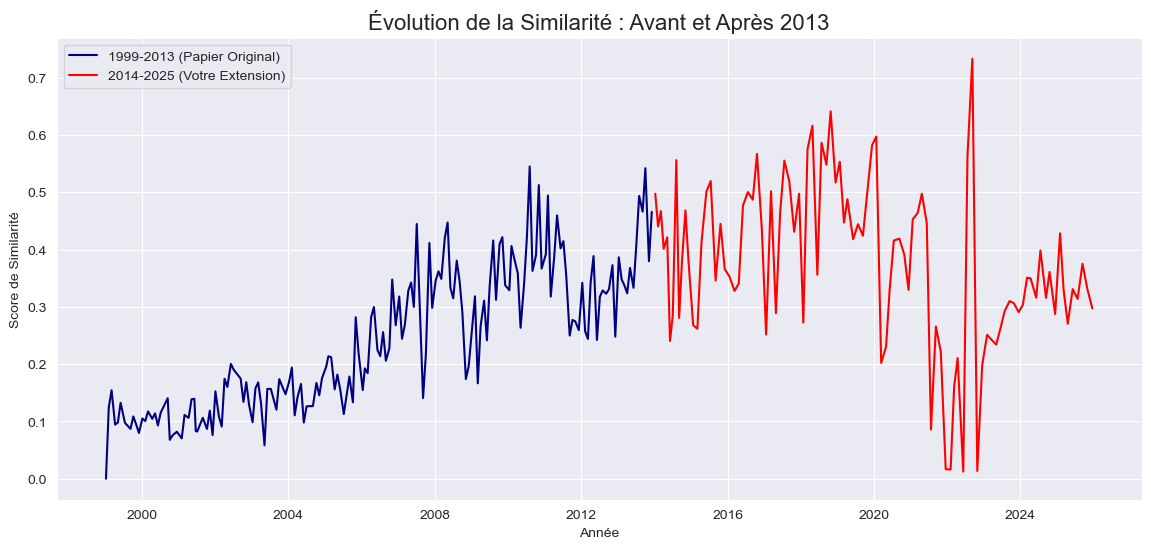

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# On s'assure que les dates sont bien au format datetime
df['date'] = pd.to_datetime(df['date'])

# Date de coupure
cutoff_date = '2014-01-01'

# On sépare les données en deux
df_before = df[df['date'] <= cutoff_date]
df_after = df[df['date'] > cutoff_date]

# Création du graphique
plt.figure(figsize=(14, 6))

# 1. La partie "Avant" (Bleu)
sns.lineplot(x='date', y='similarity_sklearn', data=df_before,
             label='1999-2013 (Papier Original)', color='navy')

# 2. La partie "Après" (Rouge)
sns.lineplot(x='date', y='similarity_sklearn', data=df_after,
             label='2014-2025 (Votre Extension)', color='red')

# Titres
plt.title('Évolution de la Similarité : Avant et Après 2013', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Score de Similarité')
plt.legend()

plt.show()

In [44]:
def clean_Q_A(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()

    # Liste des marqueurs de fin de section pertinente
    markers = [
        "we are now at your disposal",
        "we stand ready to answer any questions you may have",
        "transcript of the questions asked and the answers",
        "question"
    ]

    # Trouver le premier marqueur présent dans le texte
    for marker in markers:
        if marker in text:
            text = text.split(marker)[0]  # Garder uniquement le texte avant le marqueur
            break  # Sortir dès qu'un marqueur est trouvé

    return text

df['clean_content'] = df['content'].apply(clean_Q_A)

In [56]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import torch
import numpy as np


# 1. Charger FinBERT (version ProsusAI très utilisée en finance)
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

def get_transformer_pessimism(text):
    if not isinstance(text, str) or len(text) < 10:
        return 0

    # 2. Découpage en chunks (fenêtre glissante ou simple découpage)
    # Les textes de la BCE dépassent 512 tokens, il faut chunker
    inputs = tokenizer(text, return_tensors="pt", max_length=510, truncation=True, stride=100,
                       return_overflowing_tokens=True, padding=True)

    # On récupère les différents chunks crées par le tokenizer
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    scores = []

    # 3. Prédiction sur chaque chunk
    with torch.no_grad():
        for i in range(len(input_ids)):
            # On passe chaque chunk au modèle
            outputs = model(input_ids=input_ids[i].unsqueeze(0), attention_mask=attention_mask[i].unsqueeze(0))
            probs = softmax(outputs.logits, dim=1)
            scores.append(probs.numpy()[0])

    # scores est une liste de [Prob_Positive, Prob_Negative, Prob_Neutral]
    # Note: L'ordre des labels pour ProsusAI/finbert est souvent [Positive, Negative, Neutral], VÉRIFIER config
    # Pour ProsusAI : label 0 = positive, 1 = negative, 2 = neutral

    avg_scores = np.mean(scores, axis=0)

    # 4. Calcul du Score de Pessimisme "Façon Papier"
    # Le papier définit Pessimism = (Neg - Pos) / Total [cite: 179]
    # Avec FinBERT, on utilise les probabilités moyennes : Prob(Negative) - Prob(Positive)
    # Si le score est positif, c'est pessimiste. Si négatif, c'est optimiste.
    pessimism_score = avg_scores[1] - avg_scores[0]

    return pessimism_score

# Application sur votre DataFrame (attention, ça peut être long sur CPU)
print("Calcul du pessimisme via FinBERT en cours...")
df['pessimism_transformer'] = df['clean_content'].apply(get_transformer_pessimism)

Calcul du pessimisme via FinBERT en cours...


In [57]:
df['pessimism_transformer'].mean()

np.float32(-0.42909074)

In [61]:
# 1. Recalcul de l'interaction avec le nouveau pessimisme
# Note : log_similarity est déjà calculé dans votre code précédent
df['Interaction_Transformer_Sim'] = df['pessimism_transformer'] * df['log_similarity']

# 2. Variables pour la régression (Extension)
variables_explicatives_ext = [
    'Interaction_Transformer_Sim', # Nouvelle interaction IA
    'DELTA_MRO',
    'INFLATION',
    'OUTPUT_GAP'
]

# 3. Régression OLS
df_reg_ext = df[['ABS_CAR'] + variables_explicatives_ext].dropna()

X_ext = sm.add_constant(df_reg_ext[variables_explicatives_ext])
Y_ext = df_reg_ext['ABS_CAR']

model_ext = sm.OLS(Y_ext, X_ext)
results_ext = model_ext.fit()

print(results_ext.summary())

                            OLS Regression Results                            
Dep. Variable:                ABS_CAR   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     6.049
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           0.000627
Time:                        19:34:02   Log-Likelihood:                -449.13
No. Observations:                 166   AIC:                             906.3
Df Residuals:                     162   BIC:                             918.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             